# Tutorial: ST simulation with FEAST

In this notebook, we will use FEAST to simulate single slice with reference slice from DFPCLs.

In [1]:
from FEAST import simulator
import scanpy as sc
import numpy as np
import pandas as pd

# Tutorial 1: Simulation of Sequencing-based method slice

In [3]:
adata_path = "./example_data/151675.h5ad"
adata = sc.read_h5ad(adata_path)

# Filter genes that are detected in at least 30 cells
# Useless low expression level genes will increase the noise for modelling
sc.pp.filter_genes(adata, min_cells=30)


In [4]:
gene_list = adata.var_names.tolist()
exp_matrix = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X.copy()
stats = pd.DataFrame(
    {'mean': np.mean(exp_matrix, axis=0),
    'variance': np.var(exp_matrix, axis=0),
    'zero_prop': 1 - (np.count_nonzero(exp_matrix, axis=0) / adata.n_obs)},
    index=gene_list
).clip(lower=1e-10)

print(stats.head())


                mean  variance  zero_prop
AL669831.5  0.019488  0.019666   0.980791
NOC2L       0.162862  0.170862   0.853007
KLHL17      0.033408  0.033961   0.967428
HES4        0.220212  0.268613   0.810412
ISG15       0.264198  0.281262   0.773942


In [15]:
def plot_stats_3d(stats_df,
                  genes=None,
                  annotate_top_n=3,
                  annotate_by='mean',
                  marker_size=2,
                  log_axes=True,
                  log_eps=1e-8):
    """
    Plot 3D scatter of gene stats (mean, variance, zero_prop).
    - Smaller, fixed marker size via update_traces(marker.size).
    - Log scale on mean (x) and variance (y) when log_axes=True.
    Returns a plotly Figure.
    """
    import numpy as np
    import pandas as pd

    required = {'mean', 'variance', 'zero_prop'}
    if not required.issubset(stats_df.columns):
        raise ValueError(f"stats_df must contain columns: {required}")

    stats = stats_df.loc[stats_df.index.intersection(genes)] if genes is not None else stats_df.copy()
    if stats.shape[0] == 0:
        raise ValueError("No genes to plot after subsetting.")

    # Ensure positive values if using log axes
    if log_axes:
        stats = stats.copy()
        # Floor nonpositive to a tiny positive to keep points visible on log axes
        stats['mean'] = stats['mean'].mask(stats['mean'] <= 0, log_eps)
        stats['variance'] = stats['variance'].mask(stats['variance'] <= 0, log_eps)

    # Choose annotation metric
    if annotate_by not in stats.columns:
        annotate_by = 'mean'

    import plotly.express as px
    df = stats.reset_index().rename(columns={'index': 'gene'})

    fig = px.scatter_3d(
        df, x='mean', y='variance', z='zero_prop',
        color='mean', color_continuous_scale='Viridis',
        hover_name='gene',
        log_x=bool(log_axes), log_y=bool(log_axes), log_z=False  # zero_prop stays linear
    )

    # Set small, fixed marker size
    fig.update_traces(marker=dict(size=marker_size, opacity=0.8))

    # Optional top-N text annotations
    if annotate_top_n and annotate_top_n > 0:
        import plotly.graph_objects as go
        top = stats.sort_values(annotate_by, ascending=False).head(annotate_top_n).reset_index()
        text = go.Scatter3d(
            x=top['mean'], y=top['variance'], z=top['zero_prop'],
            mode='text',
            text=top['index'],
            textposition='top center',
            marker=dict(size=0.1, opacity=0)
        )
        fig.add_trace(text)

    fig.update_layout(
        scene=dict(
            xaxis_title='mean' + (' (log)' if log_axes else ''),
            yaxis_title='variance' + (' (log)' if log_axes else ''),
            zaxis_title='zero_prop'
        ),
        title='Gene stats (3D)'
    )
    return fig



In [14]:
plot_stats_3d(stats, genes=stats.index.tolist())

We can easily check the structure of the cloud made of features. In fact, we can directly use the feature points to regenerate the slice.

In [ ]:
recover_adata = simulator.simulate_single_slice(
        adata=adata,
        use_real_stats_directly=True, # set this hyperparameter to True to use the real stats directly
        )   
    

Starting comprehensive single slice simulation...
--- RUNNING IN DIAGNOSTIC MODE (USING REAL STATS) ---

>>> Entering DIAGNOSTIC fitting pipeline: Using REAL stats directly <<<
✓ Using optimal models: Student's T for mean, Student's T for variance, Beta for zero_prop.

--- [FITTING STATS ONLY] Calculating original gene statistics ---
✓ Statistics calculated.

--- [CONVERTING] Converting 13727 parameter sets via log-scale moment-matching ---
  > Model selection summary: {'ZIP': 13152, 'NB': 266, 'ZINB': 282, 'Poisson': 27}
  > Zero inflation rate: 97.87%
  > Overdispersion rate: 1.36%
  > Mean overdispersion: 1.15
  > Mean zero proportion: 0.870
✓ Conversion complete.
>>> Diagnostic fitting complete <<<

Generating simulated data using Perfect Pattern Preservation (sigma=0)...
Applying Guided Stochastic Rank-Based Assignment (G-SRBA)...
Applying perfect pattern preservation - maintaining exact spatial structure...
Generating new counts from fitted statistical distributions...
Applying 1

Let's run a quick and simple evaluation of the quality

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.stats import pearsonr


def safe_mean_calculation(X):
    """Safely calculate mean for both sparse and dense matrices"""
    if sp.issparse(X):
        return np.array(X.mean(axis=0)).flatten()
    else:
        return np.mean(X, axis=0)

def safe_variance_calculation(X):
    """Safely calculate variance for both sparse and dense matrices"""
    if sp.issparse(X):
        # For sparse matrices: Var(X) = E[X²] - E[X]²
        mean_X = np.array(X.mean(axis=0)).flatten()
        mean_X_squared = np.array(X.power(2).mean(axis=0)).flatten()
        return mean_X_squared - mean_X**2
    else:
        return np.var(X, axis=0)
    
def mean_correlation(real_adata, sim_adata):
    """Calculate correlation between mean gene expressions"""
    real_mean = safe_mean_calculation(real_adata.X)
    sim_mean = safe_mean_calculation(sim_adata.X)
    
    # Handle edge cases
    if len(real_mean) == 0 or len(sim_mean) == 0:
        return 0.0
    
    # Remove genes with zero variance in both datasets
    mask = (real_mean > 1e-10) & (sim_mean > 1e-10)
    if np.sum(mask) < 10:  # Need at least 10 genes for meaningful correlation
        return 0.0
        
    corr, _ = pearsonr(real_mean[mask], sim_mean[mask])
    return corr if not np.isnan(corr) else 0.0
    

def variance_correlation(real_adata, sim_adata):
    """Calculate correlation between gene variances"""
    real_var = safe_variance_calculation(real_adata.X)
    sim_var = safe_variance_calculation(sim_adata.X)
    
    # Handle edge cases
    if len(real_var) == 0 or len(sim_var) == 0:
        return 0.0
        
    # Remove genes with zero variance in both datasets
    mask = (real_var > 1e-10) & (sim_var > 1e-10)
    if np.sum(mask) < 10:
        return 0.0
        
    corr, _ = pearsonr(real_var[mask], sim_var[mask])
    return corr if not np.isnan(corr) else 0.0


In [ ]:
mean_corr = mean_correlation(adata, recover_adata)
variance_corr = variance_correlation(adata, recover_adata)
print(f"Mean correlation: {mean_corr:.4f}")
print(f"Variance correlation: {variance_corr:.4f}")

Mean correlation: 1.0000
Variance correlation: 0.9997


Therefore, after getting the 3D feature cloud, we can use statistical way (like ZINB, ZIP) to generate counts. That is why if we can find out a mathmatical way to describe the shape and the rules to generate, we can simulate the gene counts from it too. 

In [21]:
# Now simulate again but without using real stats directly
# It would take about 5-10 minutes; how about makeing a cup of coffee when running this?
simulated_adata = simulator.simulate_single_slice(
        adata=adata,
        visualize_fits=False, # you can set this to True to visualize the fitting process (but could take space)
        use_real_stats_directly=False, # set this hyperparameter to False to infer stats
        n_jobs=8)
    

Starting comprehensive single slice simulation...


--- RUNNING IN STANDARD MODE WITH PERFECT PATTERN PRESERVATION ---

>>> Entering STANDARD fitting pipeline: parameter_cloud <<<
✓ Using optimal models: Student's T for mean, Student's T for variance, Beta for zero_prop.

--- [FITTING STATS ONLY] Calculating original gene statistics ---
✓ Statistics calculated.

--- [FITTING MODELS] Fitting marginal and dependency models ---
Fitting Student's T mixture models (1-15 components)...
✓ Best model: 11 components (BIC: 21921.99)
Fitting Student's T mixture models (1-15 components)...
✓ Best model: 11 components (BIC: 23771.99)
Fitting Beta mixture models with 1-8 components...
  1 components: BIC=-23300.60, LogLik=11659.83
  2 components: BIC=-29512.92, LogLik=14780.28
  3 components: BIC=-30644.73, LogLik=15360.47
  4 components: BIC=-30897.20, LogLik=15501.00
  5 components: BIC=-31054.11, LogLik=15593.75
  6 components: BIC=-31069.98, LogLik=15615.97
  7 components: BIC=-31046.96, LogLik=15618.75
  8 components: BIC=-31015.77, LogLik=15617

In [23]:
mean_corr = mean_correlation(adata, simulated_adata)
variance_corr = variance_correlation(adata, simulated_adata)
print(f"Mean correlation (with inferred stats to simulate): {mean_corr:.4f}")
print(f"Variance correlation (with inferred stats to simulate): {variance_corr:.4f}")

Mean correlation (with inferred stats to simulate): 0.9450
Variance correlation (with inferred stats to simulate): 0.8449


We can also visualize the spatial distribution of some genes

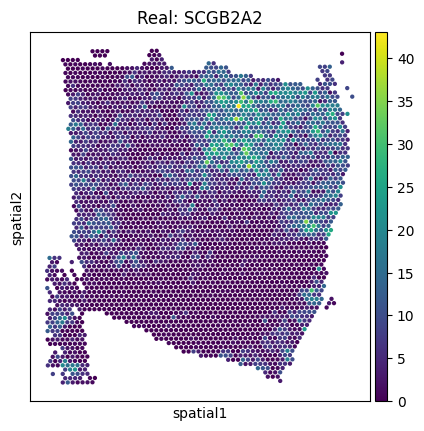

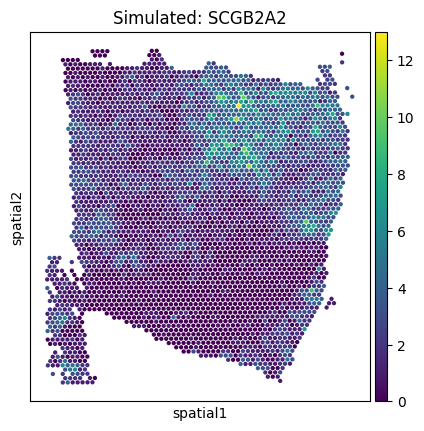

In [30]:
check_gene = "SCGB2A2"
sc.pl.spatial(adata, color=check_gene, title=f"Real: {check_gene}", spot_size = 120,alpha_img=0)
sc.pl.spatial(simulated_adata, color=check_gene, title=f"Simulated: {check_gene}", spot_size = 120)

# Tutorial 2: Simulation of imaging-based method slice, with alteration

Now let's use FEAST to generate an altered slice, based on a mouse brain MERFISH slice from Zhuang et al., 2023.

In [22]:
adata_merfish = sc.read_h5ad("./example_data/Merfish_Zhuang-ABCA-3_007.h5ad")
adata_merfish

AnnData object with n_obs × n_vars = 104187 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'n_counts', 'x', 'y', 'CellType'
    var: 'gene_symbol', 'name', 'mapped_ncbi_identifier', 'n_counts'
    obsm: 'spatial'

Because imaging-based slices usually have a smaller gene panle but lower dropout rate, the shape of feature cloud will be slightly different.

In [31]:
gene_list = adata_merfish.var_names.tolist()
exp_matrix = adata_merfish.X.toarray() if hasattr(adata_merfish.X, 'toarray') else adata_merfish.X.copy()
stats = pd.DataFrame(
    {'mean': np.mean(exp_matrix, axis=0),
    'variance': np.var(exp_matrix, axis=0),
    'zero_prop': 1 - (np.count_nonzero(exp_matrix, axis=0) / adata_merfish.n_obs)},
    index=gene_list
).clip(lower=1e-10)

print(stats.head())

plot_stats_3d(stats, genes=stats.index.tolist())

                        mean  variance  zero_prop
ENSMUSG00000024798  0.106261  0.213389   0.929281
ENSMUSG00000042385  0.005500  0.005714   0.994587
ENSMUSG00000036198  0.066371  0.479802   0.969728
ENSMUSG00000028780  0.464924  2.341224   0.831754
ENSMUSG00000015843  0.154175  0.524602   0.917427


Now let's conduct some kind of alteration of mean: for example, we can set overall mean to equal to 0.95*orginial mean

In [39]:
from FEAST.modeling.marginal_alteration import AlterationConfig

mean_fold_change = 0.95 # change here if you want to try other fold changes
alteration_config = AlterationConfig.mean_only(
            fold_change=mean_fold_change,
        )
altered_adata = simulator.simulate_single_slice(
            adata_merfish, 
            alteration_config=alteration_config,
            verbose=False,
            use_real_stats_directly=False,
            use_heuristic_search=True,
            assignment_weights = {'mean': 1, 'variance': 1, 'zero_prop': 1.0},
            top_n_to_fully_evaluate=10
        )


>>> Entering STANDARD fitting pipeline: parameter_cloud <<<
✓ Using optimal models: Student's T for mean, Student's T for variance, Beta for zero_prop.

--- [FITTING STATS ONLY] Calculating original gene statistics ---
✓ Statistics calculated.

--- [FITTING MODELS] Fitting marginal and dependency models ---
Fitting Student's T mixture models (1-15 components)...
✓ Best model: 1 components (BIC: 1983.86)
Fitting Student's T mixture models (1-15 components)...
✓ Best model: 2 components (BIC: 2736.11)
Fitting Beta mixture models with 1-8 components...
  1 components: BIC=-2908.98, LogLik=1461.52
  2 components: BIC=-3042.08, LogLik=1538.60
  3 components: BIC=-3049.71, LogLik=1552.94
  4 components: BIC=-3036.47, LogLik=1556.86
  5 components: BIC=-3016.13, LogLik=1557.23
  6 components: BIC=-2994.30, LogLik=1556.84
  7 components: BIC=-2974.02, LogLik=1557.24
  8 components: BIC=-2953.15, LogLik=1557.34
✓ Best model: 3 components (BIC=-3049.71)

--- Fitting Dependency Model (Vine Copul

Now let's check the difference between orginal and simulated mean distribution: it should change slightly but not change the overall shape.

In [40]:
def visualize_mean_distribution(real_adata, sim_adata, genes=None, log_eps=1e-8, top_n_labels=10, figsize=(5,5)):
    """
    Quick visual comparison of per-gene mean between real and simulated AnnData.
    Produces:
      - log-log scatter of means with identity line
      - MA plot (average log vs log2FC)
      - histogram of log2 fold changes
    """
    import numpy as np
    import matplotlib.pyplot as plt

    def col_mean(X):
        if hasattr(X, "toarray"):
            arr = X.toarray()
        else:
            arr = np.asarray(X)
        return np.asarray(arr).mean(axis=0).flatten()

    # intersect genes
    real_genes = list(real_adata.var_names)
    sim_genes = list(sim_adata.var_names)
    common = sorted(set(real_genes).intersection(sim_genes)) if genes is None else sorted(set(genes).intersection(real_genes).intersection(sim_genes))
    if len(common) == 0:
        raise ValueError("No common genes found between real and simulated data.")

    # mean vectors
    real_means_all = col_mean(real_adata.X)
    sim_means_all = col_mean(sim_adata.X)
    r_idx = {g:i for i,g in enumerate(real_genes)}
    s_idx = {g:i for i,g in enumerate(sim_genes)}
    idx_r = [r_idx[g] for g in common]
    idx_s = [s_idx[g] for g in common]
    means_real = real_means_all[idx_r]
    means_sim = sim_means_all[idx_s]

    # log2 fold change and avg log
    log2fc = np.log2((means_sim + log_eps) / (means_real + log_eps))
    avg_log = 0.5 * (np.log2(means_sim + log_eps) + np.log2(means_real + log_eps))

    # top genes to label
    order = np.argsort(-np.abs(log2fc))
    top_genes = [common[i] for i in order[:top_n_labels]]

    # Plot 1: log-log scatter
    plt.figure(figsize=figsize)
    plt.scatter(means_real + log_eps, means_sim + log_eps, s=8, alpha=0.6)
    mn = max(1e-12, min((means_real+log_eps).min(), (means_sim+log_eps).min()))
    mx = max((means_real+log_eps).max(), (means_sim+log_eps).max())
    plt.plot([mn, mx], [mn, mx], color='k', linestyle='--', linewidth=0.8)
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Real mean (log scale)'); plt.ylabel('Sim mean (log scale)')
    plt.title('Gene means: real vs simulated')
    # annotate top genes
    for g in top_genes:
        i = common.index(g)
        plt.text(means_real[i], means_sim[i], g, fontsize=7)
    plt.tight_layout()

    # Plot 2: MA plot
    plt.figure(figsize=(6,4))
    plt.scatter(avg_log, log2fc, s=8, alpha=0.6)
    plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
    plt.xlabel('Average log2 expression'); plt.ylabel('log2(sim/real)')
    plt.title('MA plot')
    for g in top_genes:
        i = common.index(g)
        plt.text(avg_log[i], log2fc[i], g, fontsize=7)
    plt.tight_layout()

    # Plot 3: histogram of log2FC
    plt.figure(figsize=(5,3))
    plt.hist(log2fc, bins=80, color='C0', alpha=0.9)
    plt.xlabel('log2 fold change (sim / real)'); plt.title('Log2FC distribution')
    plt.tight_layout()

    plt.show()



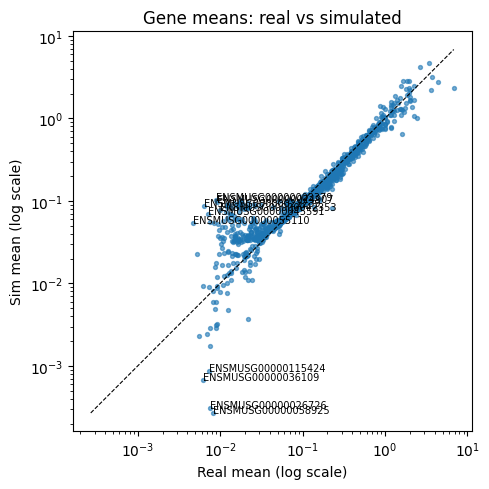

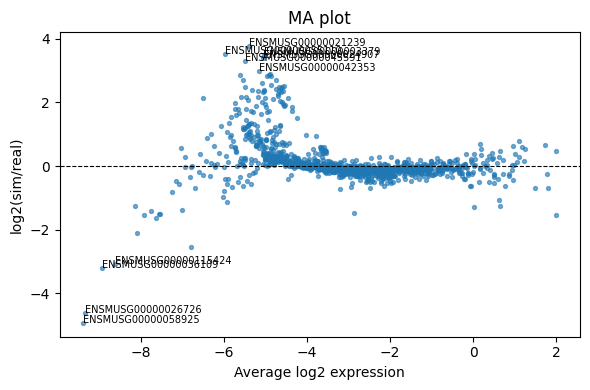

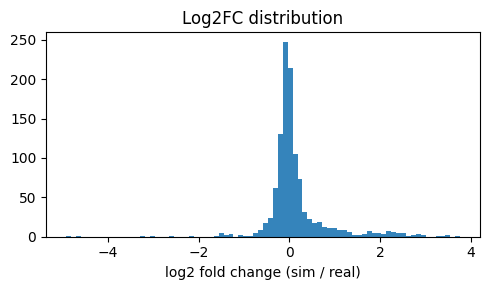

Mean correlation after alteration: 0.9053


In [41]:
visualize_mean_distribution(adata_merfish, altered_adata, genes=stats.index.tolist())
mean_corr = mean_correlation(adata_merfish, altered_adata)
print(f"Mean correlation after alteration: {mean_corr:.4f}")

Thank you for checking this tutorial of basic single slice simulation! Please feel free to contact yiru.22@intl.zju.edu.cn if you have any issue!

In [43]:
altered_adata.write_h5ad("./example_data/Merfish_Zhuang-ABCA-3_007_altered.h5ad")